In [1]:
import sys

sys.path.append('/home/caihuaiguang/DSG/pytorch-shapley-cam')

# 验证路径是否已添加
print(sys.path)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # 将 "0" 替换为你想指定的 GPU ID



['/media/caihuaiguang/miniconda3/envs/cords/lib/python38.zip', '/media/caihuaiguang/miniconda3/envs/cords/lib/python3.8', '/media/caihuaiguang/miniconda3/envs/cords/lib/python3.8/lib-dynload', '', '/media/caihuaiguang/miniconda3/envs/cords/lib/python3.8/site-packages', '/home/caihuaiguang/DSG/InfoBatch', '/home/caihuaiguang/DSG/pytorch-shapley-cam']


In [2]:
import torch

def reshape_transform(tensor, height=7, width=7):
    result = tensor.reshape(tensor.size(0),
                            height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

100%|██████████| 64/64 [00:08<00:00,  7.30it/s]


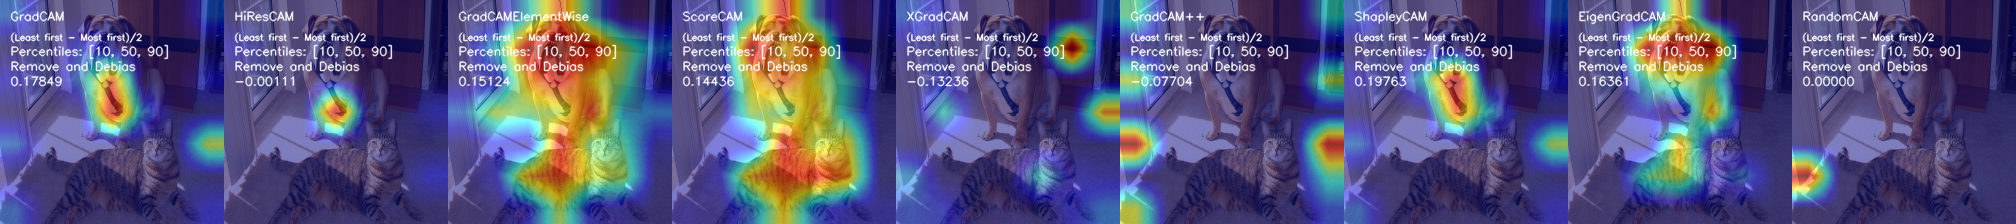

In [3]:
# import warnings
# warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import timm
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirst
from pytorch_grad_cam.metrics.road import ROADLeastRelevantFirstAverage, ROADMostRelevantFirstAverage
from pytorch_grad_cam.metrics.road import ROADCombined
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget
from pytorch_grad_cam.ablation_layer import AblationLayerVit

model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
model.eval()

model = model.cuda()

from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, ScoreCAM, EigenGradCAM, LayerCAM, AblationCAM, RandomCAM, ShapleyCAM, GradCAMElementWise, HiResCAM, XGradCAM

# Showing the metrics on top of the CAM : 
def visualize_score(visualization, score, name, percentiles):
    visualization = cv2.putText(visualization, name, (10, 20), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "(Least first - Most first)/2", (10, 40), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"Percentiles: {percentiles}", (10, 55), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
    visualization = cv2.putText(visualization, "Remove and Debias", (10, 70), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA) 
    visualization = cv2.putText(visualization, f"{score:.5f}", (10, 85), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
    return visualization
    
def benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category=243):
    methods = [("GradCAM", GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
               ("HiResCAM", HiResCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
            #    ("LayerCAM", LayerCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
               ("GradCAMElementWise", GradCAMElementWise(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
               ("ScoreCAM", ScoreCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
               ("XGradCAM", XGradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
               ("GradCAM++", GradCAMPlusPlus(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
               ("ShapleyCAM", ShapleyCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
               ("EigenGradCAM", EigenGradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
            #    ("AblationCAM", AblationCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform, ablation_layer=AblationLayerVit())),
               ("RandomCAM", RandomCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform))]

    cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
    targets = [ClassifierOutputTarget(category)]
    # targets = [ClassifierOutputSoftmaxTarget(category)]

    metric_targets = [ClassifierOutputSoftmaxTarget(category)]
    
    visualizations = []
    percentiles = [10, 50, 90]
    for name, cam_method in methods:
        with cam_method:
            attributions = cam_method(input_tensor=input_tensor, 
                                      targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
        attribution = attributions[0, :]    
        scores = cam_metric(input_tensor, attributions, metric_targets, model)
        score = scores[0]
        visualization = show_cam_on_image(cat_and_dog, attribution, use_rgb=True)
        visualization = visualize_score(visualization, score, name, percentiles)
        visualizations.append(visualization)
    return Image.fromarray(np.hstack(visualizations))

cat_and_dog_image_url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"
cat_and_dog = np.array(Image.open(requests.get(cat_and_dog_image_url, stream=True).raw))
cat_and_dog = np.float32(cat_and_dog) / 255
input_tensor = preprocess_image(cat_and_dog, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

target_layers = [model.layers[-1].blocks[-1].norm2]
model.cuda()
input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category= 243)

100%|██████████| 64/64 [00:08<00:00,  7.50it/s]


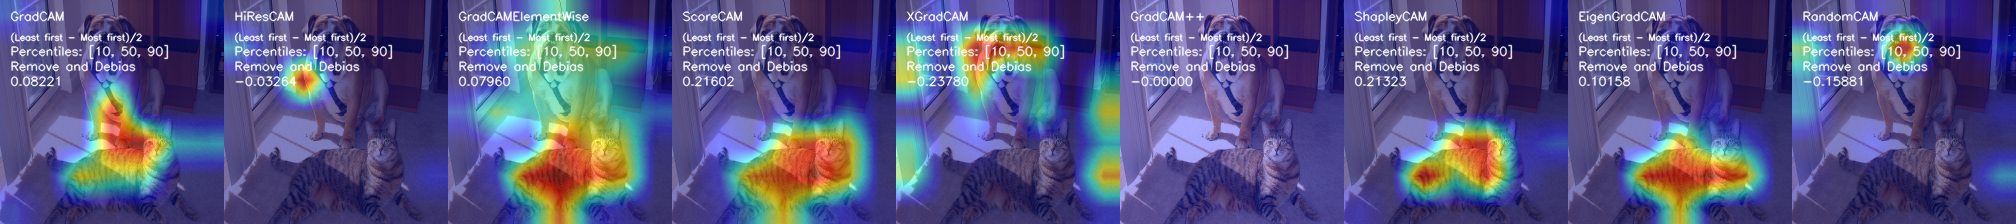

In [4]:
# Let's look how it looks for one of the dog categories (that the model is much less confident about)
np.random.seed(0)
benchmark(input_tensor, target_layers, category=282)

100%|██████████| 64/64 [00:08<00:00,  7.35it/s]


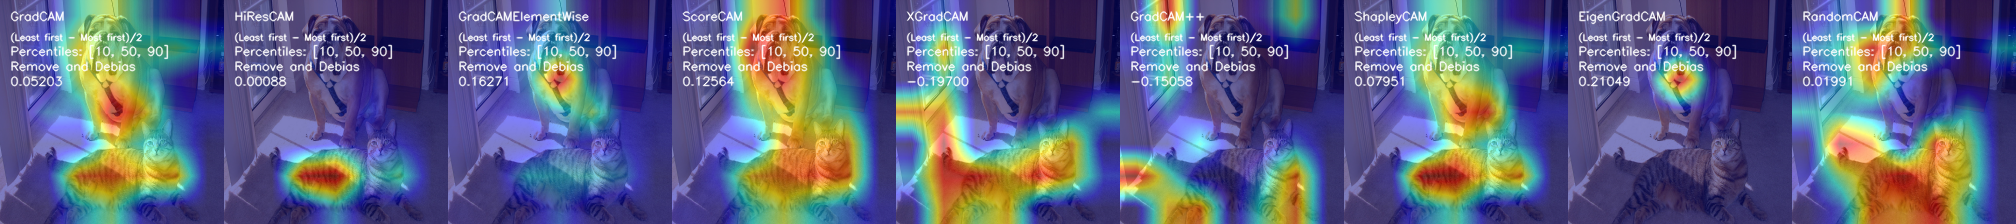

In [5]:
target_layers = [model.layers[-1].blocks[-2].norm2]
benchmark(input_tensor, target_layers, category=243)

100%|██████████| 64/64 [00:08<00:00,  7.52it/s]


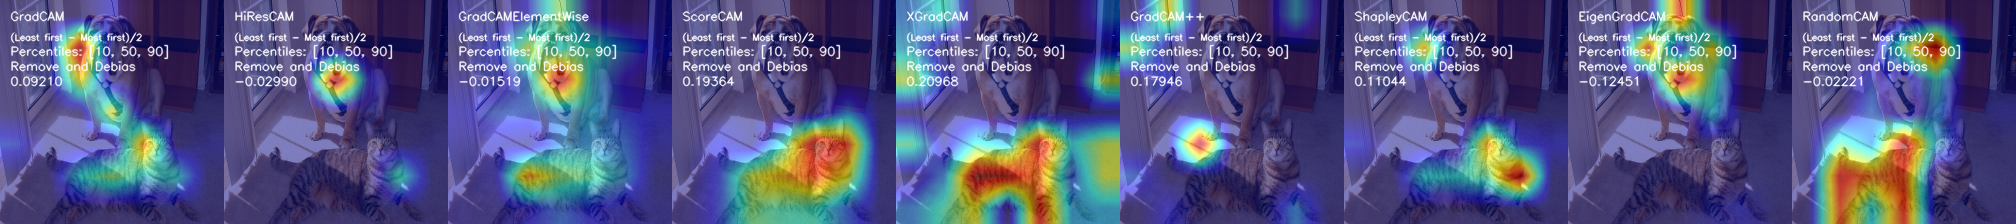

In [6]:
target_layers = [model.layers[-1].blocks[-2].norm2]
benchmark(input_tensor, target_layers, category=282)